# Nursery Scenario

In [1]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from csrl.mdp import GridMDP
from csrl.oa import OmegaAutomaton
from csrl import ControlSynthesis
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
# import scipy.special as sc
from collections import defaultdict
import matplotlib.ticker as ticker
import dill

In [2]:
def state_to_index(state,state_shape):
    return np.ravel_multi_index(state, state_shape)

def index_to_state(index,state_shape):
    return np.unravel_index(index, state_shape)

def policy_to_P(Q,csrl):
    state_shape = Q.shape[:-1]
    num_states = np.prod(state_shape)
    P = np.zeros((num_states, num_states))
    # Iterate through all states
    for flat_state_index in range(num_states):
        state = index_to_state(flat_state_index,state_shape)
        action = np.argmax(Q[state])  # Select optimal action

        # Get transitions and probabilities
        states, probs = csrl.transition_probs[state][action]
        for next_state, prob in zip(states, probs):
            next_index = state_to_index(next_state,state_shape)
            P[flat_state_index, next_index] += prob
    return P

def identify_bscc(transition_matrix):
    num_states = transition_matrix.shape[0]
    graph = defaultdict(list)

    # Construct the graph from the transition matrix
    for i in range(num_states):
        for j in range(num_states):
            if transition_matrix[i, j] > 0:  # Nonzero transition probability
                graph[i].append(j)

    # Tarjan's Algorithm for SCC
    index = 0
    stack = []
    indices = [-1] * num_states
    lowlink = [-1] * num_states
    on_stack = [False] * num_states
    sccs = []

    def tarjan(v):
        nonlocal index
        indices[v] = lowlink[v] = index
        index += 1
        stack.append(v)
        on_stack[v] = True

        for w in graph[v]:
            if indices[w] == -1:
                tarjan(w)
                lowlink[v] = min(lowlink[v], lowlink[w])
            elif on_stack[w]:
                lowlink[v] = min(lowlink[v], indices[w])

        # If v is a root node, pop the stack and generate an SCC
        if lowlink[v] == indices[v]:
            scc = []
            while True:
                w = stack.pop()
                on_stack[w] = False
                scc.append(w)
                if w == v:
                    break
            sccs.append(scc)

    # Find all SCCs
    for v in range(num_states):
        if indices[v] == -1:
            tarjan(v)

    # Filter BSCCs (no outgoing transitions)
    bsccs = []
    for scc in sccs:
        is_bscc = True
        for state in scc:
            for neighbor in graph[state]:
                if neighbor not in scc:  # Outgoing edge
                    is_bscc = False
                    break
            if not is_bscc:
                break
        if is_bscc:
            bsccs.append(set(scc))

    return bsccs

In [3]:
dill.load_session('product_MDP.pkl')
# State partition
state_shape = csrl.reward.shape
num_states = np.prod(state_shape)
B = list(zip(*np.where(csrl.reward > 0)))
R = list(zip(*np.where(csrl.reward == 0)))

print('Number of accepting states:',len(B))
print('Number of rejecting states:',len(R))
print('Number of total states:',num_states)

Number of accepting states: 53
Number of rejecting states: 987
Number of total states: 1040


Use CSRL Q-learning to obtain a memoryless policy, $\gamma_B=0.99$, $\gamma=0.99999$, number of episodes $K=100000$, lenght of epsodes $1000$, the time varying step size is the same as in CSRL. 

Here we don't care about the quality of the policy. Following the same setting is for consistency. Also the policy induce a Markov chain with all the types of states we are looking for. 

In [4]:
# Q-learning for a policy
T = 1000
K= 10000
np.random.seed(2)

Q = np.zeros(csrl.shape)

for k in tqdm(range(K)):
    state = (csrl.shape[0]-1,csrl.oa.q0)+(csrl.mdp.random_state())
    alpha = np.max((1.0*(1 - 1.5*k/K),0.001))
    epsilon = np.max((1.0*(1 - 1.5*k/K),0.01))
    for t in range(T):

        reward = csrl.reward[state]
        gamma = csrl.discountB if reward else csrl.discount

        # Follow an epsilon-greedy policy
        if np.random.rand() < epsilon or np.max(Q[state])==0:
            action = np.random.choice(csrl.A[state])  # Choose among the MDP and epsilon actions
        else:
            action = np.argmax(Q[state])

        # Observe the next state
        states, probs = csrl.transition_probs[state][action]
        next_state = states[np.random.choice(len(states),p=probs)]

        # Q-update
        Q[state][action] += alpha * (reward + gamma*np.max(Q[next_state]) - Q[state][action])
        state = next_state
        

V=np.round(np.max(Q,axis=4),2)
print('value')
print(np.round(np.max(Q,axis=4),2)[0])

100%|██████████| 10000/10000 [03:15<00:00, 51.10it/s]

value
[[[1.   1.   0.09 0.  ]
  [1.   1.   1.   1.  ]
  [1.   1.   1.   1.  ]
  [0.09 0.91 1.   1.  ]
  [0.15 0.1  1.   1.  ]]

 [[0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]]

 [[0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]]

 ...

 [[0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.07 0.   0.   0.  ]
  [0.   0.12 0.   0.  ]
  [0.09 0.   0.   0.  ]]

 [[0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]]

 [[0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]]]


Show all state types $\{B_A, B_T, \neg B_A, \neg B_R, \neg B_T\}$, finding BSCCs using Tarjan

In [5]:
# Initialize variables
bsccs = identify_bscc(policy_to_P(Q,csrl))

bsccs_mapped = [set(index_to_state(idx, state_shape) for idx in bscc) for bscc in bsccs]
# Classify and output BSCCs
accepting_bsccs = []
rejecting_bsccs = []

for i, bscc in enumerate(bsccs_mapped):
    is_accepting = any(state in B for state in bscc)
    category = "Accepting" if is_accepting else "Rejecting"
    print(f"{category} BSCC {i}: {bscc}")
    if is_accepting:
        accepting_bsccs.append(bscc)
    else:
        rejecting_bsccs.append(bscc)

# Generate all possible states as 4D tuples
S = list(np.ndindex(csrl.reward.shape))

# Calculate total states in accepting BSCCs
total_states_in_accepting_bsccs = sum(len(bscc) for bscc in accepting_bsccs)
states_in_accepting_bsccs = [state for bscc in accepting_bsccs for state in bscc]

# Calculate total states in rejecting BSCCs
R_R = [state for bscc in rejecting_bsccs for state in bscc]
states_in_rejecting_bsccs = R_R

# Calculate number of accepting states in accepting BSCCs
B_A = [state for bscc in accepting_bsccs for state in bscc if state in B]

# Calculate number of rejecting states in accepting BSCCs
R_A = [state for bscc in accepting_bsccs for state in bscc if state not in B]

# Calculate total states outside BSCCs (transient states)
states_in_bsccs = states_in_accepting_bsccs + R_R

# indices for rejecting states in rejecting BSCCs, used later for tracking
indices_R_R = [np.ravel_multi_index(state, state_shape)   for state in R_R]

# Find transient states as those not in BSCCs
transient_states = [state for state in S if state not in states_in_bsccs]
total_transient_states = len(transient_states)

# Calculate accepting and rejecting transient states
B_T = [state for state in transient_states if state in B]
R_T = [state for state in transient_states if state not in B]

# Corrected print statements with lists of states
print(f"Number of all states: {len(S)}")
print(f"Number of accepting states: {len(B)}")
print(f"Number of rejecting states: {len(R)}")
print(f"Number of transient states (outside BSCCs): {total_transient_states}")
print(f"Number of states inside all accepting BSCCs: {len(states_in_accepting_bsccs)}")
print(f"Number of states inside all rejecting BSCCs: {len(R_R)}")
print(f"Number of accepting states that are transient states (outside BSCCs): {len(B_T)}")
print(f"Number of accepting states inside all accepting BSCCs: {len(B_A)}")
print(f"Number of rejecting states that are transient states (outside BSCCs): {len(R_T)}")
print(f"Number of rejecting states inside all accepting BSCCs: {len(R_A)}")
print(f"Number of rejecting states inside all rejecting BSCCs: {len(R_R)}")

Accepting BSCC 0: {(0, 46, 3, 2), (0, 45, 0, 1), (0, 45, 3, 3), (0, 46, 0, 0), (0, 46, 2, 3), (0, 46, 2, 0), (0, 46, 4, 3), (0, 45, 1, 2), (0, 45, 2, 1), (0, 46, 1, 1), (0, 45, 0, 0), (0, 45, 3, 2), (0, 45, 4, 3), (0, 46, 2, 2), (0, 45, 2, 0), (0, 46, 4, 2), (0, 45, 2, 3), (0, 45, 1, 1), (0, 46, 1, 3), (0, 46, 1, 0), (0, 46, 3, 3), (0, 46, 0, 1), (0, 45, 4, 2), (0, 46, 2, 1), (0, 45, 2, 2), (0, 45, 1, 0), (0, 45, 1, 3), (0, 46, 1, 2)}
Rejecting BSCC 1: {(0, 51, 0, 2), (0, 51, 0, 3), (0, 51, 0, 0), (0, 51, 0, 1)}
Number of all states: 1040
Number of accepting states: 53
Number of rejecting states: 987
Number of transient states (outside BSCCs): 1008
Number of states inside all accepting BSCCs: 28
Number of states inside all rejecting BSCCs: 4
Number of accepting states that are transient states (outside BSCCs): 39
Number of accepting states inside all accepting BSCCs: 14
Number of rejecting states that are transient states (outside BSCCs): 969
Number of rejecting states inside all accep

Generating satisfication probability (ground truth). 
Solving for the least fixed point solution to
$\begin{align}
\bar{V}(s) 
&=
\begin{cases}
 1 & s\in Acc \\ 
\sum_{a\in S \backslash Acc} 
P(s,a) \bar{V}(a)
+
\sum_{b\in Acc} P(s,b) & s\notin Acc
\end{cases}. \notag
\end{align}$

100%|██████████| 50000/50000 [00:04<00:00, 11443.01it/s]


Reachability Probability Computation Complete
Final Reachability Probabilities:
[[[[1.  1.  0.  0. ]
   [1.  1.  1.  1. ]
   [1.  1.  1.  1. ]
   [0.  0.9 1.  1. ]
   [0.  0.  1.  1. ]]

  [[0.  0.  0.  0. ]
   [0.  0.  0.  0. ]
   [0.  0.  0.  0. ]
   [0.  0.  0.  0. ]
   [0.  0.  0.  0. ]]

  [[0.  0.  0.  0. ]
   [0.  0.  0.  0. ]
   [0.  0.  0.  0. ]
   [0.  0.  0.  0. ]
   [0.  0.  0.  0. ]]

  ...

  [[0.  0.  0.  0. ]
   [0.  0.  0.  0. ]
   [0.  0.  0.  0. ]
   [0.  0.  0.  0. ]
   [0.  0.  0.  0. ]]

  [[0.  0.  0.  0. ]
   [0.  0.  0.  0. ]
   [0.  0.  0.  0. ]
   [0.  0.  0.  0. ]
   [0.  0.  0.  0. ]]

  [[0.  0.  0.  0. ]
   [0.  0.  0.  0. ]
   [0.  0.  0.  0. ]
   [0.  0.  0.  0. ]
   [0.  0.  0.  0. ]]]]


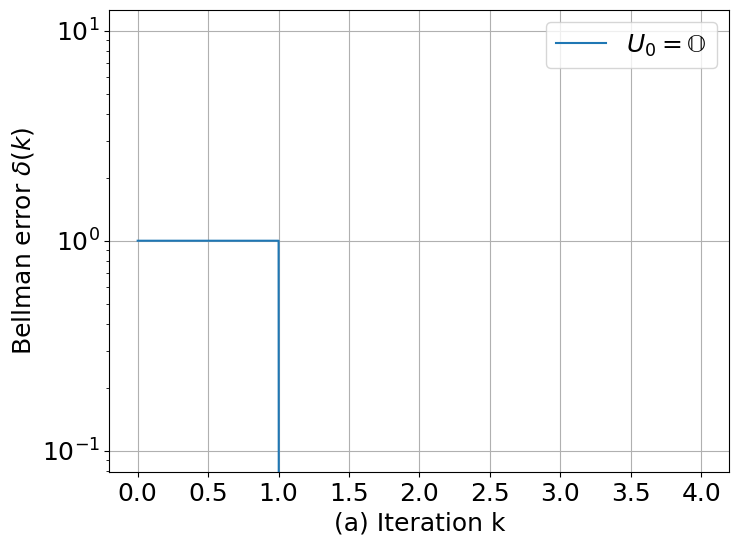

<Figure size 640x480 with 0 Axes>

In [6]:
def Q_to_P_R_Gamma(csrl, Q):
    dim = num_states
    P_pi = np.zeros((dim, dim))
    R_pi = np.zeros((dim, 1))
    gamma_vector = np.zeros(dim)

    for index in range(num_states):
        state = index_to_state(index,state_shape)
        R_pi[index] = csrl.reward[state]
        action = np.argmax(Q[state])  # Use max(Q) policy
        result = csrl.transition_probs[state][action]

        if result is None:
            print(f"Warning: No transition defined for state {state} and action {action}")
            continue

        states_array, probs_array = result
        for s, p in zip(states_array, probs_array):
            s_index = state_to_index(s,state_shape)
            P_pi[s_index, index] += p

        reward = csrl.reward[state]
        # gamma_vector[index] = csrl.discountB if reward else csrl.discount
        gamma_vector[index] = 0.99999 if reward else 1
    return P_pi.T, R_pi, gamma_vector

P_pi, R_pi, gamma_vec = Q_to_P_R_Gamma(csrl, Q)
transition_matrix = P_pi

# Initialize value table for reachability probabilities
value_reachability = np.zeros((num_states,1))


# Set value = 1 for accepting BSCC states
for bscc in accepting_bsccs:
    for state in bscc:
        state_idx = np.ravel_multi_index(state, state_shape) 
        value_reachability[state_idx] = 1.0

bellman_error_history1 = []

# Value Iteration for Reachability
K = 50000  # Number of iterations
for k in tqdm(range(K)):
    next_state_values = np.dot(transition_matrix, value_reachability)
    bellman_error_history1.append(np.max(np.abs(value_reachability - next_state_values )))
    value_reachability = next_state_values  # No reward term, only propagation


print('Reachability Probability Computation Complete')

# Transform value table into the shape of V
value_reachability_table_reshaped = value_reachability.reshape(state_shape)

# # Limit output to 2 decimal places for readability
# value_table_reshaped = np.round(value_reachability_table_reshaped, 2)

# Final reachability probabilities
reachability_probabilities = value_reachability_table_reshaped.flatten()

# Print final reachability probabilities
print("Final Reachability Probabilities:")
print(np.round(value_reachability_table_reshaped,2))
# Plot both errors in the same figure
plt.figure(figsize=(8, 6))

# plt.semilogy(true_error_history_zero_init, label='$\Vert U_{(k)} - U\Vert_\infty$')
# plt.loglog(bellman_error_history1, label='$\delta_1(k)$')
plt.semilogy(bellman_error_history1[:5], label='$U_0 = \mathrm{\mathbb{O}}$')

fontsize = 18  # Set font size for all text

plt.xlabel('(a) Iteration k', fontsize=fontsize)
plt.ylabel('Bellman error $\delta(k)$', fontsize=fontsize)
# plt.title('Error Reduction During Dynamic Programming', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.grid(True)

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.show()

# Save the plot to a file
plt.savefig("error_reduction_plot.png", dpi=300)
plt.show()

DP for value function, $U_0 = \mathbb{O}$, $\gamma_B = 1  - 1\times 10^{-4} $, $\gamma = 1$

100%|██████████| 600000/600000 [01:40<00:00, 5991.40it/s]


Value Iteration complete
finial Bellman error:
0.0
finial model-checking error:
0.07401460953908252


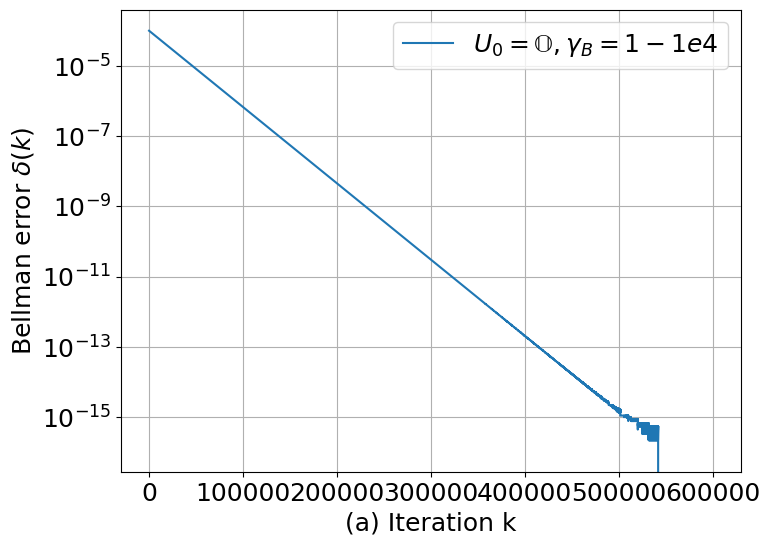

<Figure size 640x480 with 0 Axes>

In [7]:
def Q_to_P_R_Gamma2(csrl, Q):
    dim = num_states
    P_pi = np.zeros((dim, dim))
    R_pi = np.zeros((dim, 1))
    gamma_vector = np.zeros(dim)

    for index in range(num_states):
        state = index_to_state(index,state_shape)
        R_pi[index] = csrl.reward[state]*0.01
        action = np.argmax(Q[state])  # Use max(Q) policy
        result = csrl.transition_probs[state][action]

        if result is None:
            print(f"Warning: No transition defined for state {state} and action {action}")
            continue

        states_array, probs_array = result
        for s, p in zip(states_array, probs_array):
            s_index = state_to_index(s,state_shape)
            P_pi[s_index, index] += p

        reward = csrl.reward[state]
        # gamma_vector[index] = csrl.discountB if reward else csrl.discount
        gamma_vector[index] = 0.9999 if reward else 1
    return P_pi.T, R_pi, gamma_vector

P_pi, R_pi, gamma_vec = Q_to_P_R_Gamma2(csrl, Q)
transition_matrix = P_pi
reward_vector = R_pi 
gamma_vector = gamma_vec
gamma_matrix = np.diag(gamma_vector)

# Initialize value table
value_surrogate_table = np.zeros((num_states,1))

# Value Iteration
K = 600000  # Number of iterations
bellman_error_history0 = []
model_check_error_history0 = []

for k in tqdm(range(K)):
    # Compute Bellman targets
    next_state_values = np.dot(transition_matrix, value_surrogate_table)
    bellman_targets = reward_vector + np.dot(gamma_matrix, next_state_values)

    # Compute Bellman error
    bellman_error = value_surrogate_table - bellman_targets

    # Update value table using learning rate
    value_surrogate_table = bellman_targets

    bellman_error_history0.append(np.max(np.abs(bellman_error)))
    model_check_error_history0.append(np.max(np.abs(value_surrogate_table - value_reachability)))

print('Value Iteration complete')

# Transform value table into the shape of V
value_surrogate_table_reshaped = value_surrogate_table.reshape(state_shape)

print("finial Bellman error:")
print(np.max(np.abs(value_surrogate_table - (reward_vector + np.dot(gamma_matrix, np.dot(transition_matrix,value_surrogate_table))) )))

print("finial model-checking error:")
print(np.max(np.abs(reachability_probabilities - value_surrogate_table_reshaped.flatten())))
# Plot both errors in the same figure
plt.figure(figsize=(8, 6))

# plt.semilogy(true_error_history_zero_init, label='$\Vert U_{(k)} - U\Vert_\infty$')
# plt.loglog(bellman_error_history1, label='$\delta_1(k)$')
plt.semilogy(bellman_error_history0, label='$U_0 = \mathrm{\mathbb{O}}, \gamma_B = 1-1e4$')

fontsize = 18  # Set font size for all text

plt.xlabel('(a) Iteration k', fontsize=fontsize)
plt.ylabel('Bellman error $\delta(k)$', fontsize=fontsize)
# plt.title('Error Reduction During Dynamic Programming', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.grid(True)

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.show()

# Save the plot to a file
plt.savefig("error_reduction_plot.png", dpi=300)
plt.show()

DP for value function, $U_0 = \mathbb{O}$, $\gamma_B = 1  - 1\times 10^{-3} $, $\gamma = 1$

In [8]:
def Q_to_P_R_Gamma3(csrl, Q):
    dim = num_states
    P_pi = np.zeros((dim, dim))
    R_pi = np.zeros((dim, 1))
    gamma_vector = np.zeros(dim)

    for index in range(num_states):
        state = index_to_state(index,state_shape)
        R_pi[index] = csrl.reward[state]*0.1
        action = np.argmax(Q[state])  # Use max(Q) policy
        result = csrl.transition_probs[state][action]

        if result is None:
            print(f"Warning: No transition defined for state {state} and action {action}")
            continue

        states_array, probs_array = result
        for s, p in zip(states_array, probs_array):
            s_index = state_to_index(s,state_shape)
            P_pi[s_index, index] += p

        reward = csrl.reward[state]
        # gamma_vector[index] = csrl.discountB if reward else csrl.discount
        gamma_vector[index] = 0.999 if reward else 1
    return P_pi.T, R_pi, gamma_vector

P_pi, R_pi, gamma_vec = Q_to_P_R_Gamma3(csrl, Q)
transition_matrix = P_pi
reward_vector = R_pi 
gamma_vector = gamma_vec
gamma_matrix = np.diag(gamma_vector)

# Initialize value table
value_surrogate_table = np.zeros((num_states,1))

# Value Iteration
K = 600000  # Number of iterations
bellman_error_history1 = []
model_check_error_history1 = []

for k in tqdm(range(K)):
    # Compute Bellman targets
    next_state_values = np.dot(transition_matrix, value_surrogate_table)
    bellman_targets = reward_vector + np.dot(gamma_matrix, next_state_values)

    # Compute Bellman error
    bellman_error = value_surrogate_table - bellman_targets

    # Update value table using learning rate
    value_surrogate_table = bellman_targets

    bellman_error_history1.append(np.max(np.abs(bellman_error)))
    model_check_error_history1.append(np.max(np.abs(value_surrogate_table - value_reachability)))

print('Value Iteration complete')

# Transform value table into the shape of V
value_surrogate_table_reshaped = value_surrogate_table.reshape(state_shape)

print("finial Bellman error:")
print(np.max(np.abs(value_surrogate_table - (reward_vector + np.dot(gamma_matrix, np.dot(transition_matrix,value_surrogate_table))) )))

print("finial model-checking error:")
print(np.max(np.abs(reachability_probabilities - value_surrogate_table_reshaped.flatten())))

100%|██████████| 600000/600000 [01:35<00:00, 6276.15it/s]

Value Iteration complete
finial Bellman error:
0.0
finial model-checking error:
0.44561274044648974


DP for value function, $U_0 = \mathbb{O}$, $\gamma_B = 1  - 1\times 10^{-5} $, $\gamma = 1$

In [9]:
def Q_to_P_R_Gamma5(csrl, Q):
    dim = num_states
    P_pi = np.zeros((dim, dim))
    R_pi = np.zeros((dim, 1))
    gamma_vector = np.zeros(dim)

    for index in range(num_states):
        state = index_to_state(index,state_shape)
        R_pi[index] = csrl.reward[state]*0.001
        action = np.argmax(Q[state])  # Use max(Q) policy
        result = csrl.transition_probs[state][action]

        if result is None:
            print(f"Warning: No transition defined for state {state} and action {action}")
            continue

        states_array, probs_array = result
        for s, p in zip(states_array, probs_array):
            s_index = state_to_index(s,state_shape)
            P_pi[s_index, index] += p

        reward = csrl.reward[state]
        # gamma_vector[index] = csrl.discountB if reward else csrl.discount
        gamma_vector[index] = 1- 0.00001 if reward else 1
    return P_pi.T, R_pi, gamma_vector

P_pi, R_pi, gamma_vec = Q_to_P_R_Gamma5(csrl, Q)
transition_matrix = P_pi
reward_vector = R_pi 
gamma_vector = gamma_vec
gamma_matrix = np.diag(gamma_vector)

# Initialize value table
value_surrogate_table = np.zeros((num_states,1))

# Value Iteration
K = 6000000  # Number of iterations
bellman_error_history5 = []
model_check_error_history5 = []

for k in tqdm(range(K)):
    # Compute Bellman targets
    next_state_values = np.dot(transition_matrix, value_surrogate_table)
    bellman_targets = reward_vector + np.dot(gamma_matrix, next_state_values)

    # Compute Bellman error
    bellman_error = value_surrogate_table - bellman_targets

    # Update value table using learning rate
    value_surrogate_table = bellman_targets

    bellman_error_history5.append(np.max(np.abs(bellman_error)))
    model_check_error_history5.append(np.max(np.abs(value_surrogate_table - value_reachability)))

print('Value Iteration complete')

# Transform value table into the shape of V
value_surrogate_table_reshaped = value_surrogate_table.reshape(state_shape)

print("finial Bellman error:")
print(np.max(np.abs(value_surrogate_table - (reward_vector + np.dot(gamma_matrix, np.dot(transition_matrix,value_surrogate_table))) )))

print("finial model-checking error:")
print(np.max(np.abs(reachability_probabilities - value_surrogate_table_reshaped.flatten())))

100%|██████████| 6000000/6000000 [15:56<00:00, 6271.60it/s]

Value Iteration complete
finial Bellman error:
0.0
finial model-checking error:
0.007925274130245054


DP for a wrong solution, $U_0 \sim [0,1]^{m+n}$, $\gamma_B = 1  -1 \times 10^{-5} $, $\gamma = 1$

In [10]:
P_pi, R_pi, gamma_vec = Q_to_P_R_Gamma5(csrl, Q)
transition_matrix = P_pi
reward_vector = R_pi 
gamma_vector = gamma_vec
gamma_matrix = np.diag(gamma_vector)

# Initialize value table
value_surrogate_table = np.random.rand(num_states, 1).astype(np.float64)

# Value Iteration
K = 6000000 # Number of iterations
bellman_error_history3 = []
model_check_error_history3 = []
value_function_history3 = {index: [] for index in indices_R_R}

for k in tqdm(range(K)):
    # Compute Bellman targets
    next_state_values = np.dot(transition_matrix, value_surrogate_table)
    bellman_targets = reward_vector + np.dot(gamma_matrix, next_state_values)

    # Compute Bellman error
    bellman_error = value_surrogate_table - bellman_targets

    # Update value table using learning rate
    value_surrogate_table = bellman_targets

    bellman_error_history3.append(np.max(np.abs(bellman_error)))
    model_check_error_history3.append(np.max(np.abs(value_surrogate_table - value_reachability)))
    for index in indices_R_R:
        value_function_history3[index].append(value_surrogate_table[index].item())
print('Value Iteration complete')

# Transform value table into the shape of V
value_surrogate_table_reshaped = value_surrogate_table.reshape(state_shape)

print("finial Bellman error:")
print(np.max(np.abs(value_surrogate_table - (reward_vector + np.dot(gamma_matrix, np.dot(transition_matrix,value_surrogate_table))) )))

V_2discount = value_surrogate_table_reshaped.flatten()
print(np.linalg.norm(reachability_probabilities - V_2discount, ord=2))
V_2discount
value_surrogate_table.reshape(state_shape)[B_T[0]]

100%|██████████| 6000000/6000000 [15:14<00:00, 6558.61it/s]


Value Iteration complete
finial Bellman error:
0.0
16.758843133864087


0.5365606746433191

DP for a wrong solution, $U_0 = c \mathbb{I}$, $c=0.1$, $\gamma_B = 1  -1 \times 10^{-5} $, $\gamma = 1$

In [11]:
P_pi, R_pi, gamma_vec = Q_to_P_R_Gamma5(csrl, Q)
transition_matrix = P_pi
reward_vector = R_pi 
gamma_vector = gamma_vec
gamma_matrix = np.diag(gamma_vector)

# Initialize value table
value_surrogate_table = np.ones((num_states,1), dtype=np.float64)*0.1

# Value Iteration
K = 6000000  # Number of iterations
bellman_error_history4 = []
model_check_error_history4 = []
value_function_history4 = {index: [] for index in indices_R_R}

for k in tqdm(range(K)):
    # Compute Bellman targets
    next_state_values = np.dot(transition_matrix, value_surrogate_table)
    bellman_targets = reward_vector + np.dot(gamma_matrix, next_state_values)

    # Compute Bellman error
    bellman_error = value_surrogate_table - bellman_targets

    # Update value table using learning rate
    value_surrogate_table = bellman_targets

    bellman_error_history4.append(np.max(np.abs(bellman_error)))
    model_check_error_history4.append(np.max(np.abs(value_surrogate_table - value_reachability)))
    for index in indices_R_R:
        value_function_history4[index].append(value_surrogate_table[index].item())
print('Value Iteration complete')

# Transform value table into the shape of V
value_surrogate_table_reshaped = value_surrogate_table.reshape(state_shape)

print("finial Bellman error:")
print(np.max(np.abs(value_surrogate_table - (reward_vector + np.dot(gamma_matrix, np.dot(transition_matrix,value_surrogate_table))) )))

V_2discount = value_surrogate_table_reshaped.flatten()
print(np.linalg.norm(reachability_probabilities - V_2discount, ord=2))
V_2discount
value_surrogate_table.reshape(state_shape)[B_T[0]]
V_2discount

100%|██████████| 6000000/6000000 [15:56<00:00, 6269.91it/s]


Value Iteration complete
finial Bellman error:
0.0
3.2382980693615746


array([1.        , 1.        , 0.10624297, ..., 0.1       , 0.1       ,
       0.1       ])

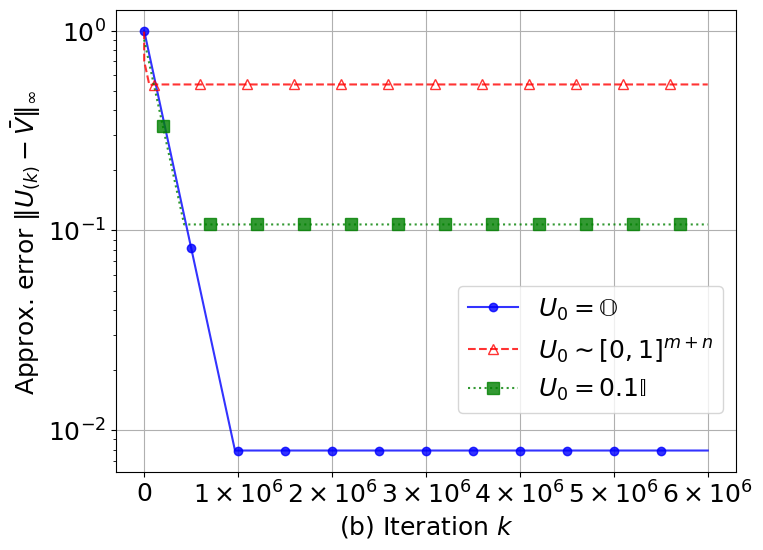

In [28]:
plt.figure(figsize=(8, 6))

# Define line styles, colors, and markers
line_styles = ['-', '--', ':']
colors = ['b', 'r', 'g']  # Blue, Red, Green
markers = ['o', '^', 's']  # Circle, Triangle, Square
markevery_intervals = [(0, 500000), (100000, 500000), (200000, 500000)]  # Adjusted for 6e6 iterations

# Plot each line with adjusted marker placement
plt.semilogy(model_check_error_history5, line_styles[0], color=colors[0], marker=markers[0], 
             markevery=markevery_intervals[0], markersize=6, alpha=0.8, label='$U_0 = \mathrm{\mathbb{O}}$')
plt.semilogy(model_check_error_history3, line_styles[1], color=colors[1], marker=markers[1], 
             markevery=markevery_intervals[1], markersize=7, markerfacecolor='none', alpha=0.8, label='$U_0 \sim [0,1]^{m+n}$')
plt.semilogy(model_check_error_history4, line_styles[2], color=colors[2], marker=markers[2], 
             markevery=markevery_intervals[2], markersize=8, alpha=0.8, label='$U_0 = 0.1  \mathrm{\mathbb{I}}$')

fontsize = 18  # Set font size for all text

plt.xlabel('(b) Iteration $k$', fontsize=fontsize)
plt.ylabel('Approx. error $\Vert U_{(k)} - \\bar{V} \Vert_\infty$ ', fontsize=fontsize)
plt.legend(fontsize=fontsize, loc='lower right', bbox_to_anchor=(1, 0.1))
plt.grid(True)

# Format x-axis in scientific notation (n × 10^m)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(
    lambda x, pos: f"${int(x / 10**int(np.log10(x)))} \\times 10^{{{int(np.log10(x))}}}$" if x >= 10 else f"{int(x)}"
))

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

# Save the plot
plt.savefig("BE_4case.png", dpi=300)
plt.show()


In [23]:
print(model_check_error_history3[-1]) 
print(model_check_error_history4[-1]) 

0.5372685678705554
0.1071327467171585


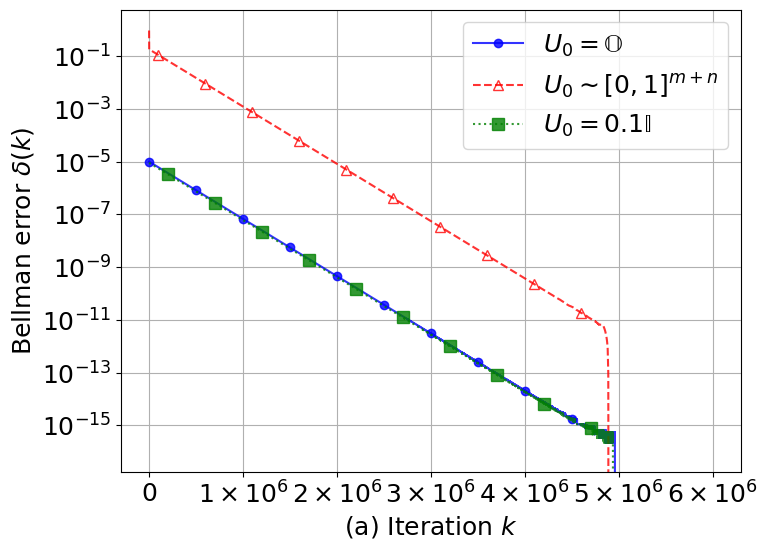

In [24]:
plt.figure(figsize=(8, 6))

# Define line styles, colors, and markers
line_styles = ['-', '--', ':']
colors = ['b', 'r', 'g']  # Blue, Red, Green
markers = ['o', '^', 's']  # Circle, Triangle, Square
markevery_intervals = [(0, 500000), (100000, 500000), (200000, 500000)]  # Adjusted for 6e6 iterations

# Plot each line with adjusted marker placement
plt.semilogy(bellman_error_history5, line_styles[0], color=colors[0], marker=markers[0], 
             markevery=markevery_intervals[0], markersize=6, alpha=0.8, label='$U_0 = \mathrm{\mathbb{O}}$')
plt.semilogy(bellman_error_history3, line_styles[1], color=colors[1], marker=markers[1], 
             markevery=markevery_intervals[1], markersize=7, markerfacecolor='none', alpha=0.8, label='$U_0 \sim [0,1]^{m+n}$')
plt.semilogy(bellman_error_history4, line_styles[2], color=colors[2], marker=markers[2], 
             markevery=markevery_intervals[2], markersize=8, alpha=0.8, label='$U_0 = 0.1  \mathrm{\mathbb{I}}$')

fontsize = 18  # Set font size for all text

plt.xlabel('(a) Iteration $k$', fontsize=fontsize)
plt.ylabel('Bellman error $\delta(k)$', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.grid(True)

# Format x-axis using scientific notation (n × 10^m)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(
    lambda x, pos: f"${int(x / 10**int(np.log10(x)))} \\times 10^{{{int(np.log10(x))}}}$" if x >= 10 else f"{int(x)}"
))

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

# Save the plot
plt.savefig("AE_4case.png", dpi=300)
plt.show()



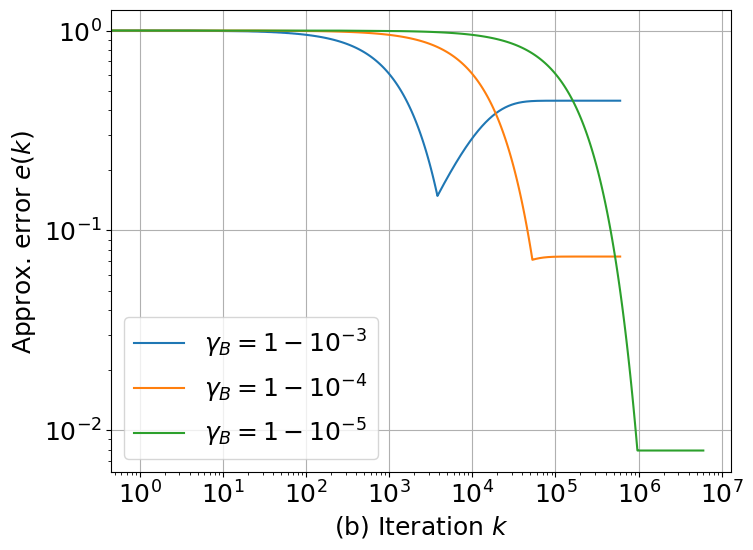

In [15]:
# Plot both errors in the same figure
plt.figure(figsize=(8, 6))

# plt.semilogy(true_error_history_zero_init, label='$\Vert U_{(k)} - U\Vert_\infty$')
plt.loglog(model_check_error_history1, label='$ \gamma_B = 1-10^{-3}$')
plt.loglog(model_check_error_history0, label='$ \gamma_B = 1-10^{-4}$')
plt.loglog(model_check_error_history5,  label='$ \gamma_B = 1-10^{-5}$')

# plt.semilogy(model_check_error_history4, label='$U_0 = 0.1  \mathrm{\mathbb{I}}, \gamma_B = 1-1e4$')

fontsize = 18  # Set font size for all text

plt.xlabel('(b) Iteration $k$', fontsize=fontsize)
plt.ylabel('Approx. error $e(k)$ ', fontsize=fontsize)
# plt.title('Error Reduction During Dynamic Programming', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.grid(True)

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

# Save the plot to a file
plt.savefig("AE_2", dpi=300)
plt.show()

In [16]:
model_check_error_history0[-1]

0.07401460953908252

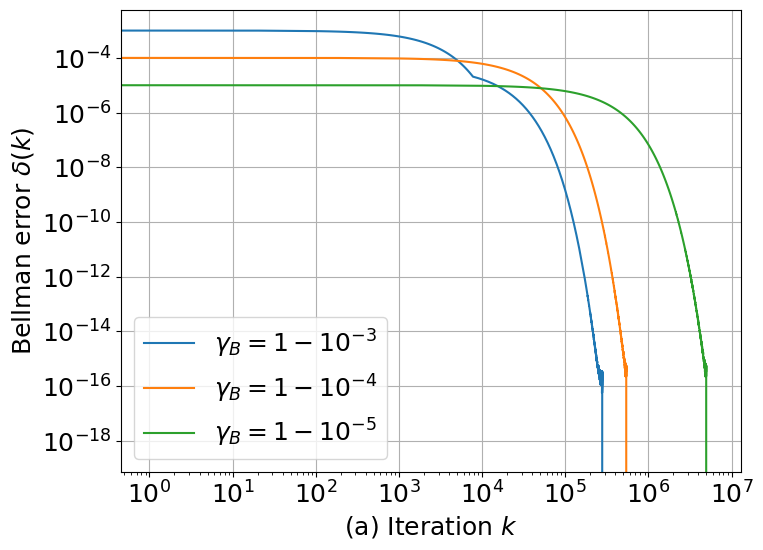

In [17]:
# Plot both errors in the same figure
plt.figure(figsize=(8, 6))

# plt.semilogy(true_error_history_zero_init, label='$\Vert U_{(k)} - U\Vert_\infty$')
# plt.loglog(bellman_error_history1, label='$\delta_1(k)$')
plt.loglog(bellman_error_history1, label='$ \gamma_B = 1-10^{-3}$')
plt.loglog(bellman_error_history0, label='$ \gamma_B = 1-10^{-4}$')
plt.loglog(bellman_error_history5, label='$ \gamma_B = 1-10^{-5}$')

# plt.loglog(bellman_error_history4, label='$U_0 = 0.1  \mathrm{\mathbb{I}}, \gamma_B = 1-1e4$')

fontsize = 18  # Set font size for all text

plt.xlabel('(a) Iteration $k$', fontsize=fontsize)
plt.ylabel('Bellman error $\delta(k)$', fontsize=fontsize)
# plt.title('Error Reduction During Dynamic Programming', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.grid(True)

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)


# Save the plot to a file
plt.savefig("BE_2.png", dpi=300)
plt.show()

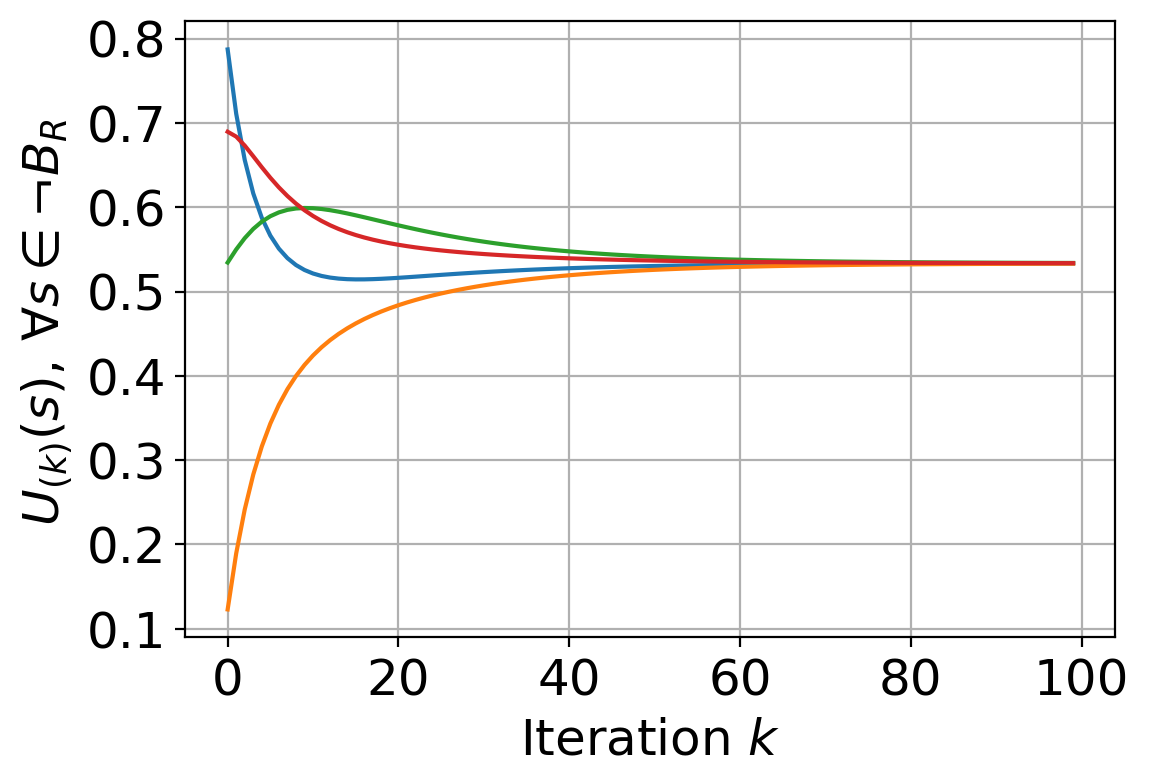

In [18]:
import matplotlib.colors as mcolors
# Generate unique colors for each BSCC
bscc_colors = {i: color for i, color in enumerate(mcolors.TABLEAU_COLORS)}

# Initialize a set to track which BSCCs have been added to the legend
legend_bsccs = set()

plt.figure(figsize=(6, 4),dpi=200)
for index in indices_R_R:
    state = np.unravel_index(index, state_shape)
    
    # Find the BSCC this state belongs to
    bscc_index = next(
        (i for i, bscc in enumerate(bsccs_mapped) if state in bscc), 
        None
    )
    
    # Use the BSCC color
    # color = bscc_colors.get(bscc_index, "black")  # Default to black if no BSCC match
    
    # Plot the line for the state
    plt.plot(value_function_history3[index][:100], label=f"BSCC {bscc_index}" if bscc_index not in legend_bsccs else None)
    
    # Add BSCC to the legend set
    legend_bsccs.add(bscc_index)

# Add legend for BSCCs only
handles, labels = plt.gca().get_legend_handles_labels()
unique_legend = {label: handle for handle, label in zip(handles, labels) if label is not None}

fontsize = 18  # Set font size for all text

# plt.title("Approx. Value function in rejecting BSCCs", fontsize=fontsize)
plt.xlabel('Iteration $k$', fontsize=fontsize)
plt.ylabel(r' $U_{(k)}(s), \, \forall s \in \neg B_R$', fontsize=fontsize)
# plt.legend(fontsize=fontsize)
plt.grid(True)

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

# Show and save the plot

plt.savefig("Plot_BSCC_update.png", dpi=300)
plt.show()